# Neural Networks from Scratch - Backpropogation
https://nnfs.io/order


In [2]:
from nnfs.datasets import vertical_data
import matplotlib.pyplot as plt
import numpy as np
import nnfs

nnfs.init()

# Create dataset
X, y = vertical_data(samples=100, classes=3)

# plot the dataset
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', edgecolors='k')
# plt.title('Vertical Data Distribution')


What if we just randomly change weights each epoch?

Strategy 1

In [9]:
from nnfs.datasets import vertical_data
import matplotlib.pyplot as plt
import numpy as np
import nnfs

nnfs.init()


# Dense layer
class Layer_Dense:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Calculate output values from input
        self.output = np.maximum(0, inputs)

# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

# Create dataset
# X, y = vertical_data(samples=100, classes=3)
X,y = spiral_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3) # First dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # Second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10_000): # 10,000
# for iteration in range(100_000): # 100,000
# for iteration in range(1_000_000): # 1,000,000
# for iteration in range(1_000_000_000): # 1,000,000,000

    # Generate a new set of weights for iteration
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Perform a forward pass through activation function
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print("New set of weights found, iteration: ", iteration, "loss: ", loss, "acc: ", accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss

New set of weights found, iteration:  0 loss:  1.1008568 acc:  0.3333333333333333
New set of weights found, iteration:  1 loss:  1.0990819 acc:  0.3333333333333333
New set of weights found, iteration:  3 loss:  1.098629 acc:  0.3333333333333333
New set of weights found, iteration:  11 loss:  1.0985013 acc:  0.3333333333333333
New set of weights found, iteration:  58 loss:  1.0984759 acc:  0.36666666666666664
New set of weights found, iteration:  87 loss:  1.0984341 acc:  0.3933333333333333
New set of weights found, iteration:  389 loss:  1.0983855 acc:  0.3333333333333333
New set of weights found, iteration:  602 loss:  1.0983611 acc:  0.3433333333333333
New set of weights found, iteration:  812 loss:  1.0983337 acc:  0.3333333333333333
New set of weights found, iteration:  1765 loss:  1.0982677 acc:  0.37
New set of weights found, iteration:  3766 loss:  1.0980942 acc:  0.3333333333333333
New set of weights found, iteration:  3979 loss:  1.0980837 acc:  0.3333333333333333
New set of w

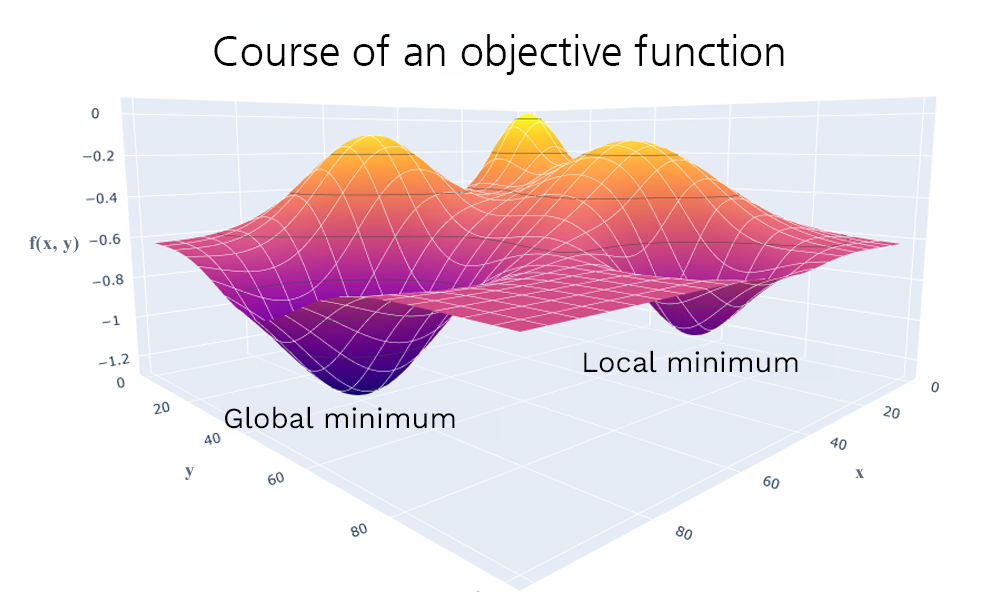

Need to update weights and bias - not randomly make new ones

Strategy 2

In [8]:
from nnfs.datasets import vertical_data, spiral_data
import matplotlib.pyplot as plt
import numpy as np
import nnfs


nnfs.init()


# Create dataset
# X, y = vertical_data(samples=100, classes=3)
X, y = spiral_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3) # First dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # Second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10_000): # 10,000
# for iteration in range(100_000): # 100,000
# for iteration in range(1_000_000): # 1,000,000
# for iteration in range(1_000_000_000): # 1,000,000,000

    # Update weights with some small random values
    dense1.weights -= 0.05 * np.random.randn(2, 3)
    dense1.biases -= 0.05 * np.random.randn(1, 3)
    dense2.weights -= 0.05 * np.random.randn(3, 3)
    dense2.biases -= 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Perform a forward pass through activation function
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print("New set of weights found, iteration: ", iteration, "loss: ", loss, "acc: ", accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
    else:
        dense1.weights = best_dense1_weights.copy() 
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration:  0 loss:  1.1008464 acc:  0.3333333333333333
New set of weights found, iteration:  1 loss:  1.0995156 acc:  0.3333333333333333
New set of weights found, iteration:  2 loss:  1.0991638 acc:  0.3333333333333333
New set of weights found, iteration:  3 loss:  1.0981847 acc:  0.3333333333333333
New set of weights found, iteration:  4 loss:  1.0980605 acc:  0.32
New set of weights found, iteration:  6 loss:  1.0971155 acc:  0.36
New set of weights found, iteration:  8 loss:  1.0969378 acc:  0.34
New set of weights found, iteration:  12 loss:  1.0965102 acc:  0.36
New set of weights found, iteration:  17 loss:  1.0962443 acc:  0.35333333333333333
New set of weights found, iteration:  20 loss:  1.0945652 acc:  0.32
New set of weights found, iteration:  33 loss:  1.0940638 acc:  0.43
New set of weights found, iteration:  38 loss:  1.0940375 acc:  0.37
New set of weights found, iteration:  41 loss:  1.0939184 acc:  0.39666666666666667
New set of weights found

But how do we optimize this? How much do we add or substract to each weight?


Let's think about this in 2D

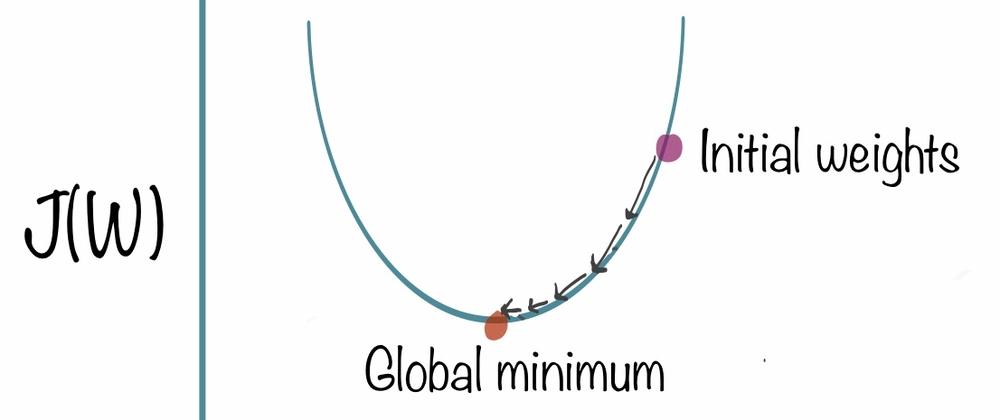

back to notes for backprop

## Chain Rule - not going to go over code part of this because its a bit too confusing and would rather focus time elsewhere

In [ ]:

# Forward Pass
x = [1.0, -2.0, 3.0] # input values
w = [-3.0, -1.0, 2.0] # weights
b = 1.0 # bias

# Multiplying inputs by weights
xw0 = x[0] * w[0] # 1.0 * -3.0
xw1 = x[1] * w[1] # -2.0 * -1.0
xw2 = x[2] * w[2] # 3.0 * 2.0

print("Inputs * weights: ", xw0, xw1, xw2) # -3.0, 2.0, 6.0

# Adding weighted inputs and a bias
z = xw0 + xw1 + xw2 + b
print("sum(Inputs * weights + bias): ", z) # 6.0

# ReLU activation function
y = max(z, 0)
print("ReLU output: ", y) # 6.0

# Backward Pass

# The derivative from the next layer (L/y) - just as an example
# In a real neural network, this would come from the loss function during backpropagation.
dvalue = 1.0

# Calculates the gradient of ReLU’s output with respect to z during backpropagation.
# If z > 0, the ReLU derivative is 1, meaning the loss gradient will fully propagate back.
# If z <= 0, the derivative is 0, stopping the gradient from passing back through z, effectively "blocking" updates to earlier weights.
# This calculation uses the chain rule: we multiply the incoming gradient (dvalue) by the local gradient of ReLU to get the overall gradient with respect to z.
drelu_dz = dvalue * (1. if z > 0 else 0.)

print("Gradient of ReLU: ", drelu_dz)

# Applying the chain rule to compute gradients of ReLU output w.r.t each weighted input and bias for backpropagation
dsum_dxw0 = 1
dsum_dxw1 = 1
dsum_dxw2 = 1
dsum_db = 1
drelu_dxw0 = drelu_dz * dsum_dxw0  
drelu_dxw1 = drelu_dz * dsum_dxw1
drelu_dxw2 = drelu_dz * dsum_dxw2
drelu_db = drelu_dz * dsum_db
print("Partial derivatives (gradients) of ReLU output w.r.t xw0, xw1, xw2, and b:", drelu_dxw0, drelu_dxw1, drelu_dxw2, drelu_db)

Inputs * weights:  -3.0 2.0 6.0
sum(Inputs * weights + bias):  6.0
ReLU output:  6.0
Gradient of ReLU:  1.0
Partial derivatives (gradients) of ReLU output w.r.t xw0, xw1, xw2, and b: 1.0 1.0 1.0 1.0


<!-- 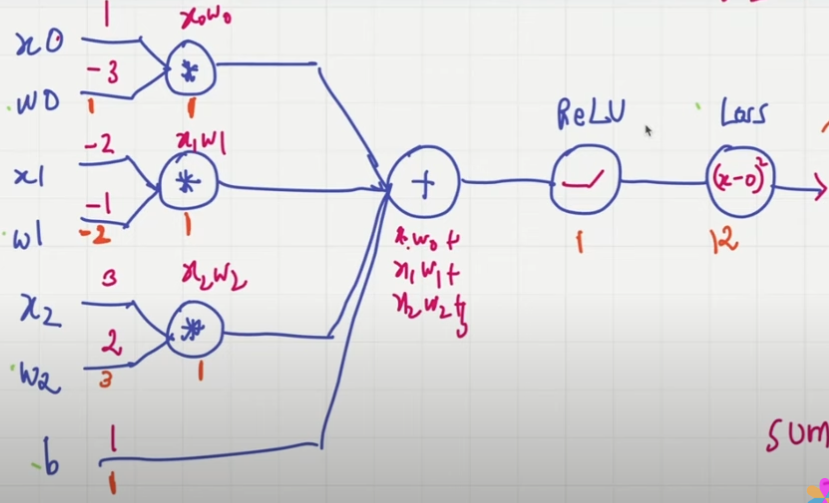


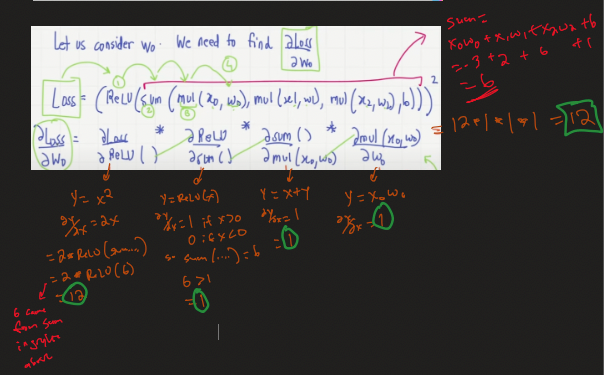


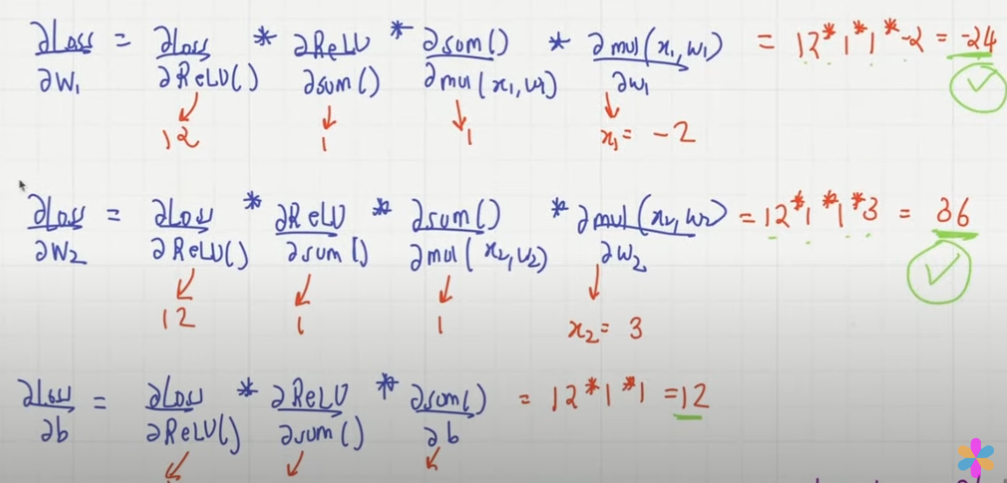 -->

In [9]:

# Forward Pass
x = [1.0, -2.0, 3.0] # input values
w = [-3.0, -1.0, 2.0] # weights
b = 1.0 # bias

# Multiplying inputs by weights
xw0 = x[0] * w[0] # 1.0 * -3.0
xw1 = x[1] * w[1] # -2.0 * -1.0
xw2 = x[2] * w[2] # 3.0 * 2.0

print("Inputs * weights: ", xw0, xw1, xw2) # -3.0, 2.0, 6.0

# Adding weighted inputs and a bias
z = xw0 + xw1 + xw2 + b
print("sum(Inputs * weights + bias): ", z) # 6.0

# ReLU activation function
y = max(z, 0)
print("ReLU output: ", y) # 6.0

# Backward Pass

# The derivative from the next layer
dvalue = 1.0

# Calculates the gradient of ReLU’s output with respect to z during backpropagation.
# If z > 0, the ReLU derivative is 1, meaning the loss gradient will fully propagate back.
# If z <= 0, the derivative is 0, stopping the gradient from passing back through z, effectively "blocking" updates to earlier weights.
# This calculation uses the chain rule: we multiply the incoming gradient (dvalue) by the local gradient of ReLU to get the overall gradient with respect to z.
drelu_dz = dvalue * (1. if z > 0 else 0.)

print("Gradient of ReLU: ", drelu_dz)

# Applying the chain rule to compute gradients of ReLU output w.r.t each weighted input and bias for backpropagation
dsum_dxw0 = 1
dsum_dxw1 = 1
dsum_dxw2 = 1
dsum_db = 1
drelu_dxw0 = drelu_dz * dsum_dxw0  
drelu_dxw1 = drelu_dz * dsum_dxw1
drelu_dxw2 = drelu_dz * dsum_dxw2
drelu_db = drelu_dz * dsum_db
print("Partial derivatives (gradients) of ReLU output w.r.t xw0, xw1, xw2, and b:", drelu_dxw0, drelu_dxw1, drelu_dxw2, drelu_db)\


# Calculating partial derivatives of ReLU output w.r.t each original input x[i] and weight w[i]
# Here, we apply the chain rule again to backpropagate gradients through the multiplication operations in the forward pass.
dmul_dx0 = w[0]
dmul_dx1 = w[1]
dmul_dx2 = w[2]
dmul_dw0 = x[0]
dmul_dw1 = x[1]
dmul_dw2 = x[2]

drelu_dx0 = drelu_dxw0 * dmul_dx0 
drelu_dw0 = drelu_dxw0 * dmul_dw0

drelu_dx1 = drelu_dxw1 * dmul_dx1
drelu_dw1 = drelu_dxw1 * dmul_dw1

drelu_dx2 = drelu_dxw2 * dmul_dx2
drelu_dw2 = drelu_dxw2 * dmul_dw2

print("Final gradients w.r.t original inputs and weights:", drelu_dx0, drelu_dw0, drelu_dx1, drelu_dw1, drelu_dx2, drelu_dw2)


#       ----- Animations -----
# Backpropagation Example
# https://nnfs.io/pro/

Inputs * weights:  -3.0 2.0 6.0
sum(Inputs * weights + bias):  6.0
ReLU output:  6.0
Gradient of ReLU:  1.0
Partial derivatives (gradients) of ReLU output w.r.t xw0, xw1, xw2, and b: 1.0 1.0 1.0 1.0
Final gradients w.r.t original inputs and weights: -3.0 1.0 -1.0 -2.0 2.0 3.0


Can watch video above if still confused

In [ ]:
# Forward Pass
x = [1.0, -2.0, 3.0] # input values
w = [-3.0, -1.0, 2.0] # weights
b = 1.0 # bias

# Multiplying inputs by weights
xw0 = x[0] * w[0] # 1.0 * -3.0
xw1 = x[1] * w[1] # -2.0 * -1.0
xw2 = x[2] * w[2] # 3.0 * 2.0

print("Inputs * weights: ", xw0, xw1, xw2) # -3.0, 2.0, 6.0

# Adding weighted inputs and a bias
z = xw0 + xw1 + xw2 + b
print("sum(Inputs * weights + bias): ", z) # 6.0

# ReLU activation function
y = max(z, 0)
print("ReLU output: ", y) # 6.0

# Backward Pass

# The derivative from the next layer
dvalue = 1.0

# Simplified gradient calculation using the chain rule
# Gradient of ReLU output with respect to each input and weight
drelu_dx0 = dvalue * (1. if z > 0 else 0.) * w[0]
drelu_dx1 = dvalue * (1. if z > 0 else 0.) * w[1]
drelu_dx2 = dvalue * (1. if z > 0 else 0.) * w[2]
drelu_dw0 = dvalue * (1. if z > 0 else 0.) * x[0]
drelu_dw1 = dvalue * (1. if z > 0 else 0.) * x[1]
drelu_dw2 = dvalue * (1. if z > 0 else 0.) * x[2]
drelu_db = dvalue * (1. if z > 0 else 0.)

print("Final gradients w.r.t original inputs and weights:", drelu_dx0, drelu_dw0, drelu_dx1, drelu_dw1, drelu_dx2, drelu_dw2)
print("Gradient w.r.t. bias: ", drelu_db)

dx = [drelu_dx0, drelu_dx1, drelu_dx2] # Gradients on inputs
dw = [drelu_dw0, drelu_dw1, drelu_dw2] # Gradients on weights
db = drelu_db # Gradient on bias, just 1 bias here

print("\nCurrent Weights: ", w, "\nCurrent Bias: ", b)

# Applying a fraction of the gradients to current weights and bias
w[0] += -0.001 * dw[0]
w[1] += -0.001 * dw[1]
w[2] += -0.001 * dw[2]
b += - 0.001 * db

print("\nModified Weights: ", w, "\nModified Bias: ", b)

# Another Forward pass

# Multiplying inputs by weights
xw0 = x[0] * w[0]
xw1 = x[1] * w[1]
xw2 = x[2] * w[2]
print("\nInputs * new weights: ", xw0, xw1, xw2)

# Adding weighted inputs and a bias
z = xw0 + xw1 + xw2 + b
print("sum(Inputs * new weights + new bias): ", z)

# # ReLU activation function
y = max(z, 0)
print("ReLU output: ", y) 


#       ----- Animations -----
# Simplifying Neuron Derivative
# https://nnfs.io/com/

Inputs * weights:  -3.0 2.0 6.0
sum(Inputs * weights + bias):  6.0
ReLU output:  6.0
Final gradients w.r.t original inputs and weights: -3.0 1.0 -1.0 -2.0 2.0 3.0
Gradient w.r.t. bias:  1.0

Current Weights:  [-3.0, -1.0, 2.0] 
Current Bias:  1.0

Modified Weights:  [-3.001, -0.998, 1.997] 
Modified Bias:  0.999

Inputs * new weights:  -3.001 1.996 5.9910000000000005
sum(Inputs * new weights + new bias):  5.985
ReLU output:  5.985


Start back here

Now how do we add this to out classes?

In [ ]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()


# Dense layer
class Layer_Dense:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
    # Backward Pass
    def backward(self, dvalues):
        # dweights → how much to adjust weights
        # dbiases → how much to adjust biases
        # dinputs → gradient signal passed back to earlier layers
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input
        self.output = np.maximum(0, inputs)
    
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities
    
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, 
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output
# of the previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Perform a forward pass of our training data through this layer
dense1.forward(X)

# Perform a forward pass through activation function.
# It takes the output of the first Dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer.
# It takes outputs of activation function of first layer as inputs.
dense2.forward(activation1.output)

# Perform a forward pass through the activation/loss function.
# It takes the output of second Dense layer here and returns loss.
loss = loss_activation.forward(dense2.output, y)

# Let's see output of the first few samples
print(loss_activation.output[:5])

# Print loss value
print("Loss:", loss)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)

# Print accuracy
print("Accuracy:", accuracy)

# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

# Print gradients
print("\nDense1 weights:\n", dense1.dweights)
print("Dense1 biases:\n", dense1.dbiases)
print("\nDense2 weights:\n", dense2.dweights)
print("Dense2 biases:\n", dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
Loss: 1.0986104
Accuracy: 0.34

Dense1 weights:
 [[ 1.5766358e-04  7.8368575e-05  4.7324404e-05]
 [ 1.8161036e-04  1.1045571e-05 -3.3096316e-05]]
Dense1 biases:
 [[-3.6055347e-04  9.6611722e-05 -1.0367142e-04]]

Dense2 weights:
 [[ 5.4410957e-05  1.0741142e-04 -1.6182236e-04]
 [-4.0791339e-05 -7.1678100e-05  1.1246944e-04]
 [-5.3011299e-05  8.5817286e-05 -3.2805994e-05]]
Dense2 biases:
 [[-1.0732794e-05 -9.4590941e-06  2.0027626e-05]]


So how do we actually optimize this? We can use Stochastic Gradient Descent (SGD)

In [7]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data


nnfs.init()


# Dense layer
class Layer_Dense:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
    # Backward Pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input
        self.output = np.maximum(0, inputs)
    
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities
    
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, 
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# SGD (Stochastic Gradient Descent) Optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is the default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases


# Create dataset
X, y = spiral_data(samples=100, classes=3)
# X, y = vertical_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of the previous layer here) and 3 output values
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD()


# Train in loop
for epoch in range(10_000):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function.
    # It takes the output of the first Dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer.
    # It takes outputs of activation function of first layer as inputs.
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function.
    # It takes the output of second Dense layer here and returns loss.
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)


    # print(f"epoch: {epoch}, " +
    #       f"acc: {accuracy:.3f}, " +
    #       f"loss: {loss:.3f}, ")
    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:.3f}, " +
              f"loss: {loss:.3f}, ")

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

#       ----- Animations -----
# Live SGD Optimization for neural network with Learning Rate of 1.0.
# https://nnfs.io/pup/

epoch: 0, acc: 0.360, loss: 1.099, 
epoch: 100, acc: 0.400, loss: 1.087, 
epoch: 200, acc: 0.417, loss: 1.077, 
epoch: 300, acc: 0.420, loss: 1.076, 
epoch: 400, acc: 0.400, loss: 1.074, 
epoch: 500, acc: 0.403, loss: 1.071, 
epoch: 600, acc: 0.417, loss: 1.067, 
epoch: 700, acc: 0.440, loss: 1.062, 
epoch: 800, acc: 0.430, loss: 1.055, 
epoch: 900, acc: 0.387, loss: 1.064, 
epoch: 1000, acc: 0.400, loss: 1.064, 
epoch: 1100, acc: 0.440, loss: 1.062, 
epoch: 1200, acc: 0.403, loss: 1.060, 
epoch: 1300, acc: 0.390, loss: 1.052, 
epoch: 1400, acc: 0.397, loss: 1.051, 
epoch: 1500, acc: 0.430, loss: 1.090, 
epoch: 1600, acc: 0.403, loss: 1.050, 
epoch: 1700, acc: 0.427, loss: 1.042, 
epoch: 1800, acc: 0.407, loss: 1.029, 
epoch: 1900, acc: 0.443, loss: 1.025, 
epoch: 2000, acc: 0.417, loss: 1.059, 
epoch: 2100, acc: 0.470, loss: 1.011, 
epoch: 2200, acc: 0.417, loss: 1.019, 
epoch: 2300, acc: 0.483, loss: 1.022, 
epoch: 2400, acc: 0.500, loss: 0.987, 
epoch: 2500, acc: 0.457, loss: 1.008,

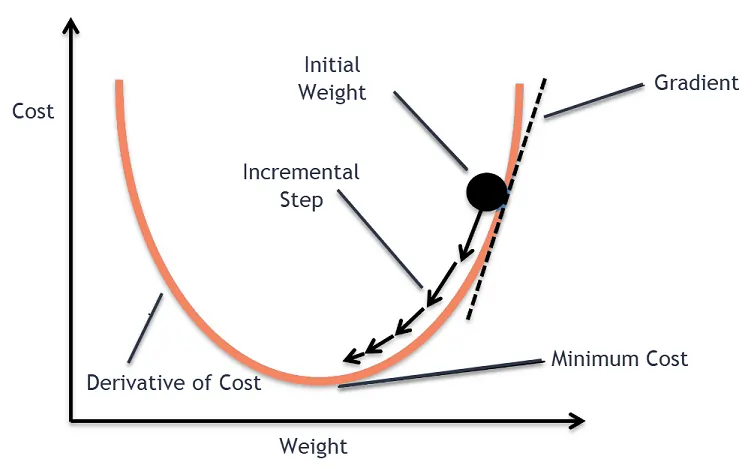

How do we control how much we step? learning rate intro and decay/momuntum

Back to notes

In [12]:
%matplotlib widget


import numpy as np
import nnfs
from nnfs.datasets import spiral_data
# import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.use("TkAgg")   # or "QtAgg" if you have Qt installed
import matplotlib.pyplot as plt
plt.ion()

nnfs.init()


# Dense layer
class Layer_Dense:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
    # Backward Pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input
        self.output = np.maximum(0, inputs)
    
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities
    
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


# Common loss class
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, 
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# SGD (Stochastic Gradient Descent) Optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is the default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        
        # if we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them 
            # filled with zeros
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = (self.momentum * layer.weight_momentums) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = (self.momentum * layer.bias_momentums) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentums = bias_updates
        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of the previous layer here) and 3 output values
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
# Decay options: 1e-2=0.01, 1e-3=0.001, 1e-4=0.0001
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.9)

# Set up the main figure with a GridSpec layout and adjusted width ratios
fig = plt.figure(figsize=(14, 6))  # Increase figure width for more space
gs = GridSpec(3, 2, width_ratios=[2, 1.5], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.9)

# Define subplots: main decision boundary plot on the left, and stacked loss/accuracy/learning rate on the right
ax_main = fig.add_subplot(gs[:, 0])  # Decision boundary plot spans both rows on the left
ax_loss = fig.add_subplot(gs[0, 1])  # Loss plot on the top right
ax_accuracy = fig.add_subplot(gs[1, 1])  # Accuracy plot on the middle right
ax_lr = fig.add_subplot(gs[2, 1])  # Learning rate plot on the bottom right

# Initialize titles for the Loss and Accuracy plots
ax_loss.set_title("Loss: N/A")
ax_accuracy.set_title("Accuracy: N/A")
ax_lr.set_title("Learning Rate: N/A")

# Configure the main plot (decision boundary)
ax_main.set_title("Decision Boundary")
ax_main.set_xlabel("Feature 1")
ax_main.set_ylabel("Feature 2")

# Configure the loss plot
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")

# Configure the accuracy plot
ax_accuracy.set_xlabel("Epoch")
ax_accuracy.set_ylabel("Accuracy")

# Configure the learning rate plot
ax_lr.set_xlabel("Epoch")
ax_lr.set_ylabel("Learning Rate")

# Configure the loss and accuracy lines
loss_line, = ax_loss.plot([], [], color='brown')  # Initialize an empty line for loss
accuracy_line, = ax_accuracy.plot([], [], color='blue')  # Initialize an empty line for accuracy
lr_line, = ax_lr.plot([], [], color='green')  # Learning rate line


# Lists to store loss, accuracy, and learning rate values for plotting
losses = []
accuracies = []
learning_rates = []

# Training loop
for epoch in range(10_001):
    
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y) * 100  # Convert to percentage
    # accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f"epoch: {epoch}, " +
            f"acc: {accuracy:.3f}, " +
            f"loss: {loss:.3f}, " +
            f"lr: {optimizer.current_learning_rate}")

    # Store accuracy, loss, and current learning rate for plotting
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    # Update plots more frequently
    if epoch % 20 == 0 or epoch == 10_001 - 1:  # Update every 20 epochs
        
        # Update the decision boundary plot
        ax_main.clear()
        ax_main.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=10)

        # Define a grid over the feature space
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

        # Predict on the grid
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        dense1.forward(grid_points)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        predictions_grid = np.argmax(dense2.output, axis=1)
        predictions_grid = predictions_grid.reshape(xx.shape)

        # Plot decision boundary
        ax_main.contourf(xx, yy, predictions_grid, cmap='brg', alpha=0.3)
        ax_main.set_title(f"Decision Boundary at Epoch {epoch}")
        ax_main.set_xlabel("Feature 1")
        ax_main.set_ylabel("Feature 2")

        # Update the loss and accuracy plot titles with the current values
        ax_loss.set_title(f"Loss: {loss:.3f}")
        ax_accuracy.set_title(f"Accuracy: {accuracy:.2f}%")

        # Update the loss and accuracy plots
        loss_line.set_data(range(len(losses)), losses)
        accuracy_line.set_data(range(len(accuracies)), accuracies)

        lr_line.set_data(range(len(learning_rates)), learning_rates)
        ax_lr.set_title(f"Learning Rate: {optimizer.current_learning_rate:.6f}")
        
        # Update axis limits to fit the new data
        ax_loss.relim()
        ax_loss.autoscale_view()
        ax_accuracy.relim()
        ax_accuracy.autoscale_view()
        ax_lr.relim()
        ax_lr.autoscale_view()

        # Redraw the plot
        plt.draw()
        plt.pause(0.001)  # Pause briefly to allow the plot to update


plt.ioff()  # Turn off interactive mode
plt.show()  # Keep the plot open at the end


#       ----- Animations -----
# Live SGD Optimization for neural network with a 1e-3 Decaying Learning Rate from 1.0, along with momentum (0.5).
# https://nnfs.io/ram/

# Live SGD Optimization for neural network with a 1e-3 Decaying Learning Rate from 1.0, along with momentum (0.9).
# https://nnfs.io/map/


epoch: 0, acc: 36.000, loss: 1.099, lr: 1.0
epoch: 100, acc: 44.333, loss: 1.054, lr: 0.9099181073703367
epoch: 200, acc: 46.000, loss: 0.990, lr: 0.8340283569641367
epoch: 300, acc: 49.333, loss: 0.900, lr: 0.7698229407236336
epoch: 400, acc: 64.667, loss: 0.720, lr: 0.7147962830593281
epoch: 500, acc: 76.667, loss: 0.574, lr: 0.66711140760507
epoch: 600, acc: 80.000, loss: 0.501, lr: 0.6253908692933083
epoch: 700, acc: 80.667, loss: 0.453, lr: 0.5885815185403178
epoch: 800, acc: 81.667, loss: 0.422, lr: 0.5558643690939411
epoch: 900, acc: 82.000, loss: 0.401, lr: 0.526592943654555
epoch: 1000, acc: 83.667, loss: 0.386, lr: 0.5002501250625312
epoch: 1100, acc: 85.000, loss: 0.376, lr: 0.4764173415912339
epoch: 1200, acc: 86.333, loss: 0.362, lr: 0.45475216007276037
epoch: 1300, acc: 85.333, loss: 0.356, lr: 0.43497172683775553
epoch: 1400, acc: 86.333, loss: 0.351, lr: 0.4168403501458941
epoch: 1500, acc: 86.000, loss: 0.345, lr: 0.4001600640256102
epoch: 1600, acc: 86.333, loss: 0.34

There are many other optimizers that we won't go over, so I encourage you to take a look at them! Popular ones are Adam, AdaGrad, RMSprop, etc.

In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


nnfs.init()


# Dense layer
class Layer_Dense:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
    # Backward Pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input
        self.output = np.maximum(0, inputs)
    
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities
    
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


# Common loss class
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, 
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# SGD (Stochastic Gradient Descent) Optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is the default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        
        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them 
            # filled with zeros
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = (self.momentum * layer.weight_momentums) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = (self.momentum * layer.bias_momentums) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentums = bias_updates
        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad (Adaptive Gradient) Optimizer
class Optimizer_Adagrad:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += (-self.current_learning_rate * layer.dweights) / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += (-self.current_learning_rate * layer.dbiases) / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop (Root Mean Square Propagation) Optimizer
class Optimizer_RMSprop:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache = (self.rho * layer.weight_cache) + (1 - self.rho) * layer.dweights**2 
        layer.bias_cache = (self.rho * layer.bias_cache) + (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += (-self.current_learning_rate * layer.dweights) / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += (-self.current_learning_rate * layer.dbiases) / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam (Adaptive Momentum) Optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, "weight_cache"):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update momentum with current gradients
        layer.weight_momentums = (self.beta_1 * layer.weight_momentums) + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = (self.beta_1 * layer.bias_momentums) + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = (self.beta_2 * layer.weight_cache) + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = (self.beta_2 * layer.bias_cache) + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += (-self.current_learning_rate * weight_momentums_corrected) / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += (-self.current_learning_rate * bias_momentums_corrected) / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of the previous layer here) and 3 output values
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
# Decay options: 1e-2=0.01, 1e-3=0.001, 1e-4=0.0001, 1e-5=0.00001
# optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)


CREATE_PLOT = False

if CREATE_PLOT:
    # Set up the main figure with a GridSpec layout and adjusted width ratios
    fig = plt.figure(figsize=(14, 6))  # Increase figure width for more space
    gs = GridSpec(3, 2, width_ratios=[2, 1.5], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.9)

    # Define subplots: main decision boundary plot on the left, and stacked loss/accuracy/learning rate on the right
    ax_main = fig.add_subplot(gs[:, 0])  # Decision boundary plot spans both rows on the left
    ax_loss = fig.add_subplot(gs[0, 1])  # Loss plot on the top right
    ax_accuracy = fig.add_subplot(gs[1, 1])  # Accuracy plot on the middle right
    ax_lr = fig.add_subplot(gs[2, 1])  # Learning rate plot on the bottom right

    # Initialize titles for the Loss and Accuracy plots
    ax_loss.set_title("Loss: N/A")
    ax_accuracy.set_title("Accuracy: N/A")
    ax_lr.set_title("Learning Rate: N/A")

    # Configure the main plot (decision boundary)
    ax_main.set_title("Decision Boundary")
    ax_main.set_xlabel("Feature 1")
    ax_main.set_ylabel("Feature 2")

    # Configure the loss plot
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")

    # Configure the accuracy plot
    ax_accuracy.set_xlabel("Epoch")
    ax_accuracy.set_ylabel("Accuracy")

    # Configure the learning rate plot
    ax_lr.set_xlabel("Epoch")
    ax_lr.set_ylabel("Learning Rate")

    # Configure the loss and accuracy lines
    loss_line, = ax_loss.plot([], [], color='brown')  # Initialize an empty line for loss
    accuracy_line, = ax_accuracy.plot([], [], color='blue')  # Initialize an empty line for accuracy
    lr_line, = ax_lr.plot([], [], color='green')  # Learning rate line

    # Lists to store loss, accuracy, and learning rate values for plotting
    losses = []
    accuracies = []
    learning_rates = []


# Training loop
for epoch in range(10_001):
    
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y) * 100  # Convert to percentage
    # accuracy = np.mean(predictions == y)

    print(f"epoch: {epoch}, " +
          f"acc: {accuracy:.3f}, " +
          f"loss: {loss:.3f}, " +
          f"lr: {optimizer.current_learning_rate}")

    if CREATE_PLOT:
        # Store accuracy, loss, and current learning rate for plotting
        losses.append(loss)
        accuracies.append(accuracy)
        learning_rates.append(optimizer.current_learning_rate)

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    if CREATE_PLOT:
        # Update plots more frequently
        if epoch % 20 == 0 or epoch == 10_001 - 1:  # Update every 20 epochs
            
            # Update the decision boundary plot
            ax_main.clear()
            ax_main.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=10)

            # Define a grid over the feature space
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

            # Predict on the grid
            grid_points = np.c_[xx.ravel(), yy.ravel()]
            dense1.forward(grid_points)
            activation1.forward(dense1.output)
            dense2.forward(activation1.output)
            predictions_grid = np.argmax(dense2.output, axis=1)
            predictions_grid = predictions_grid.reshape(xx.shape)

            # Plot decision boundary
            ax_main.contourf(xx, yy, predictions_grid, cmap='brg', alpha=0.3)
            ax_main.set_title(f"Decision Boundary at Epoch {epoch}")
            ax_main.set_xlabel("Feature 1")
            ax_main.set_ylabel("Feature 2")

            # Update the loss and accuracy plot titles with the current values
            ax_loss.set_title(f"Loss: {loss:.3f}")
            ax_accuracy.set_title(f"Accuracy: {accuracy:.2f}%")

            # Update the loss and accuracy plots
            loss_line.set_data(range(len(losses)), losses)
            accuracy_line.set_data(range(len(accuracies)), accuracies)

            lr_line.set_data(range(len(learning_rates)), learning_rates)
            ax_lr.set_title(f"Learning Rate: {optimizer.current_learning_rate:.6f}")
            
            # Update axis limits to fit the new data
            ax_loss.relim()
            ax_loss.autoscale_view()
            ax_accuracy.relim()
            ax_accuracy.autoscale_view()
            ax_lr.relim()
            ax_lr.autoscale_view()

            # Redraw the plot
            plt.draw()
            plt.pause(0.001)  # Pause briefly to allow the plot to update

if CREATE_PLOT:
    plt.ioff()  # Turn off interactive mode
    plt.show()  # Keep the plot open at the end


# Validate the model

# Create the test dataset
X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)

print(f"validation, acc: {accuracy:.3f}, loss: {loss:.3f}")

#       ----- Animations -----
# Testing Data intuition
# https://nnfs.io/zog/

epoch: 0, acc: 36.000, loss: 1.099, lr: 0.05
epoch: 1, acc: 33.000, loss: 1.096, lr: 0.05
epoch: 2, acc: 32.333, loss: 1.091, lr: 0.0499999750000125
epoch: 3, acc: 40.667, loss: 1.084, lr: 0.04999995000005
epoch: 4, acc: 41.667, loss: 1.083, lr: 0.0499999250001125
epoch: 5, acc: 41.000, loss: 1.080, lr: 0.0499999000002
epoch: 6, acc: 43.333, loss: 1.078, lr: 0.049999875000312506
epoch: 7, acc: 43.333, loss: 1.075, lr: 0.04999985000045001
epoch: 8, acc: 42.667, loss: 1.073, lr: 0.0499998250006125
epoch: 9, acc: 42.333, loss: 1.071, lr: 0.04999980000080001
epoch: 10, acc: 41.333, loss: 1.069, lr: 0.0499997750010125
epoch: 11, acc: 42.333, loss: 1.067, lr: 0.049999750001249996
epoch: 12, acc: 41.667, loss: 1.065, lr: 0.049999725001512486
epoch: 13, acc: 45.333, loss: 1.062, lr: 0.04999970000179999
epoch: 14, acc: 45.333, loss: 1.059, lr: 0.04999967500211249
epoch: 15, acc: 46.000, loss: 1.056, lr: 0.049999650002449984
epoch: 16, acc: 46.000, loss: 1.053, lr: 0.049999625002812485
epoch: 17

And that is training a neural network!! 